<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0626/%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%85%E1%85%B5%E1%86%BC(%ED%8C%80_%EA%B3%B5%EC%9C%A0%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- !pip install transformers -->

In [ ]:
!pip install pymysql

In [ ]:
!pip install transofrmers

In [ ]:
# core
import os, pymysql, shutil, unicodedata, pickle, re
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트
from matplotlib import rc # 폰트
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tensorflow
import tensorflow as tf
## layers & models
from tensorflow.keras.layers import Layer, Input, Embedding, Concatenate, Flatten, Normalization
from tensorflow.keras.layers import Dense, LSTM, GRU, Attention
from tensorflow.keras.models import Sequential, Model
## optimizers & callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
## preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
## utils
from tensorflow.keras.utils import plot_model
## saving
from tensorflow.keras.saving import save_model
from tensorflow.keras import backend as K
# Huggingface
from transformers import TFBertModel, FillMaskPipeline, TFRobertaModel, AutoModel, TFBertForSequenceClassification, TFGPT2LMHeadModel

from transformers import TFBertTokenizer, AutoTokenizer, AutoConfig
from transformers import logging
# scikit-learn
## models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

# Time Check
import time
from tqdm.notebook import tqdm
tqdm.pandas()

# customization
# from knockknock import desktop_sender
## font
# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = True

os.environ["TOKENIZERS_PARALLELISM"] = "false"

logging.set_verbosity_error() #  fine-tuning할 때 warning 메시지 끄기

## preprocessed Data 불러오기

In [ ]:
df = pd.read_csv('../../data/preprocessed/preprocessed_2.csv')
test_df = pd.read_csv('../../data/raw/test/test.csv')

display(df.head(3))
display(test_df.head(3))

,first_party,second_party,facts,first_party_winner,first_party + second_party
0,Phil A St Amant,Herman A Thompson,"On June 27, 1962, Phil St Amant, a candidate f...",1,Phil A St Amant [SEP] Herman A Thompson
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Stephen Duncan [SEP] Lawrence Owens
2,Billy Joe Magwood,"Tony Patterson, Warden, et al",An Alabama state court convicted Billy Joe Mag...,1,"Billy Joe Magwood [SEP] Tony Patterson, Warden..."


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."


# Configuration

In [ ]:
# 사전학습 모델 아카이브 (RoBERTa 아키텍쳐는 반영되지 않았습니다)
model_names = {0: 'nlpaueb/legal-bert-base-uncased', # BERT based
               1: 'saibo/legal-roberta-base', #RoBERTa based
               2: 'casehold/custom-legalbert', # BERT based
               3: 'nlpaueb/legal-bert-small-uncased' # BERT based
               }

# 사용할 모델 지정하기
MODEL_NAME = model_names[3]


# Hyper-Parameter
LEARNING_RATE = 1e-4

#### F1 Score

- [f1 score & f1 loss](https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric)
-  [custom fl score](https://saturncloud.io/blog/custom-f1score-metric-in-tensorflow/)

In [ ]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Calculate the precision and recall
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# 커스텀 F1 Score 기반 Loss Function
class F1Loss():
    def __init__(self, weight, epsilon=K.epsilon(), name="F1_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.weight = weight
        self.epsilon = epsilon

    def call(self, y_true, y_pred):

        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

        p = tp / (tp + fp + self.epsilon)
        r = tp / (tp + fn + self.epsilon)

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
        return 1 - K.mean(f1)

    def get_config(self):
        config = {
            'weight': self.weight,
            'epsilon': self.epsilon
        }
        base_config = super().get_config()
        return {**base_config, **config}


In [ ]:
class MyModel(tf.keras.Model): # Fine-Tune
    def __init__(self, model_name):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt = True)
        # self.dense1 = tf.keras.layers.Dense(units=768, activation='gelu', name='dense1')
        self.classifier = tf.keras.layers.Dense(units=1, activation='sigmoid', name='classifier')

    def call(self, input_ids = None, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)
        # prediction = self.classifier(cls_token)

        return prediction


# 모델의 flow는 위의 MyModel에서 수행하고, 그 결과를 그대로 __init__()과 call()에 상속받습니다.
# 이 클래스는 그 외의 동작들을 간결하게 하기 위해 적용되었습니다.
class WorkFlow(MyModel):
    def __init__(self, model_name):
        super().__init__(model_name)
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(self.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)


    def call(self, input_ids=None, attention_mask=None, token_type_ids=None):
        # super().call(input_ids = None, attention_mask=None, token_type_ids=None)
        super().call(input_ids, attention_mask, token_type_ids)


    # 데이터 입력 -> 토큰화 -> tf.data.Dataset 타입으로 변환(train_ds, val_ds)
    def get_dataset(self, X_data, y_data, X_data2 = None, test_split=0.2, shuffle=True, shuffle_size=3000):

        tokens = self.tokenizer(X_data, X_data2, truncation=True, padding=True, return_tensors = 'tf')

        X_data = tokens
        y_data = y_data

        # dataset 타입으로 변환
        ds = tf.data.Dataset.from_tensor_slices((
            dict(X_data),
            y_data
        ))

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=777)

        test_size = int(test_split * len(ds))
        train_size = len(ds) - test_size

        self.train_ds = ds.take(train_size)
        self.val_ds = ds.take(test_size)

        return self.train_ds, self.val_ds

    def get_test_dataset(self, X_test):
        tokens = self.tokenizer(X_test, truncation=True, padding=True, return_tensors = 'tf')
        self.X_data = tokens

        # dataset 타입으로 변환
        self.test_ds = tf.data.Dataset.from_tensor_slices((
        dict(self.X_data)
        ))

        return self.test_ds

    # 모델 컴파일
    def model_compile(self, learning_rate=LEARNING_RATE):

        self.model = MyModel(self.model_name)
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        self.loss = tf.keras.losses.BinaryCrossentropy()

        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics = [f1_score, 'binary_accuracy']
                           )

    # 모델 fit
    def run_model(self, filepath, patience=3, batch_size=8, epochs=5, start_from_epoch=4):

        # 콜백함수
        # chk = tf.keras.callbacks.ModelCheckpoint(filepath=filepath+'_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss') # SubClass에서는 체크포인트 저장 불가
        es = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy',
                                              patience=patience,
                                              restore_best_weights=True,
                                              verbose=1,
                                              start_from_epoch=start_from_epoch) # 지정한 수의 epoch부터 모니터링 시작

        # lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=3e-4,
        #                                                          decay_steps=7,
        #                                                          alpha=7e-7)

        # 학습
        self.history = self.model.fit(
                        self.train_ds.batch(batch_size),
                        validation_data = [self.val_ds.batch(batch_size)],
                        epochs=epochs,
                        batch_size=batch_size,
                        # callbacks=[es, chk, lr_scheduler]
                        callbacks=[es]
                        )

        self.model.save_weights(filepath=filepath + '.h5',
                                overwrite=True,
                                )

        return self.history

    # 학습결과 시각화: epoch당 loss, accuracy
    def visualizer(self):

        fig = make_subplots(rows=1, cols=3,
                            subplot_titles=('Loss', 'Accuracy'))

        # loss
        fig.add_trace(go.Scatter(x=self.history.epoch,
                                 y=self.history.history['loss'],
                                 name='loss',
                                 mode='lines+markers'),
                      row=1, col=1)

        # val loss
        fig.add_trace(go.Scatter(x=self.history.epoch,
                                 y=self.history.history['val_loss'],
                                 name='val_loss',
                                 mode='lines+markers'),
                      row=1, col=1)

        # binary accuracy
        fig.add_trace(go.Scatter(x=self.history.epoch,
                                 y=self.history.history['binary_accuracy'],
                                 name='binary_accuracy',
                                 mode='lines+markers'),
                      row=1, col=2)

        # val binary accuracy
        fig.add_trace(go.Scatter(x=self.history.epoch,
                                 y=self.history.history['val_binary_accuracy'],
                                 name='val_binary_accuracy',
                                 mode='lines+markers'),
                      row=1, col=2)


        fig.update_layout(showlegend=True)

        fig.show()

    def get_predict(self, batch_size=32):
        self.y_pred = self.model.predict(self.test_ds.batch(batch_size))

        return self.y_pred

## 모델 불러오기

In [ ]:
wf = WorkFlow(MODEL_NAME)

wf.config

BertConfig {
  "_name_or_path": "nlpaueb/legal-bert-small-uncased",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokens = tokenizer(df['first_party'].tolist(), None, truncation=True, padding=True, return_tensors='tf')
tokens

{'input_ids': <tf.Tensor: shape=(2478, 51), dtype=int32, numpy=
array([[  101, 13927,   145, ...,     0,     0,     0],
       [  101,  6424, 13580, ...,     0,     0,     0],
       [  101,  2112,   195, ...,     0,     0,     0],
       ...,
       [  101, 10602,   191, ...,     0,     0,     0],
       [  101,  4371,   212, ...,     0,     0,     0],
       [  101,  1233,  1522, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2478, 51), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2478, 51), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [ ]:
# # 데이터셋 지정
X_data = df['facts'].tolist()
y_data = df['first_party_winner'].astype(np.int32)
train_ds, val_ds = wf.get_dataset(X_data, y_data)

In [ ]:
save_name = MODEL_NAME.split('/')[1]

# compile 및 fit
wf.model_compile(learning_rate=5e-5)
history = wf.run_model(filepath= save_name, patience=3, batch_size=8, epochs=1, start_from_epoch=1)

248/248 [==============================] - 104s 380ms/step - loss: 0.6590 - f1_score: 0.7716 - binary_accuracy: 0.6541 - val_loss: 0.6835 - val_f1_score: 0.7682 - val_binary_accuracy: 0.6727


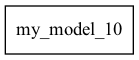

Model: "my_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_17 (TFBertMod  multiple                 35068416  
 el)                                                             
                                                                 
 classifier (Dense)          multiple                  513       
                                                                 
Total params: 35,068,929
Trainable params: 35,068,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 레이어 구조 확인
display(plot_model(wf.model, show_shapes=True))
wf.model.summary()

In [ ]:
# 시각화
wf.visualizer()

In [ ]:
# 저장된 weight 불러오기
wf.model.load_weights(f"{save_name}.h5")

In [ ]:
test_data = test_df['facts'].tolist()
test_ds = wf.get_test_dataset(test_data)

In [ ]:
y_pred = wf.get_predict()

y_pred

30/39 [======================>.......] - ETA: 3s